In [1]:
import copy
import os, sys
os.chdir('..')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats.mstats import zscore

# loa my modules
from src.utils import load_pkl, unflatten
from src.visualise import *

import joblib
import pickle

# Built-in modules #
import random

# Third party modules #
import numpy, scipy, matplotlib, pandas
from matplotlib import pyplot
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

In [2]:
model_path = './models/SCCA_Yeo7nodes_revision_4_0.80_0.50.pkl'
label_path = './references/names.csv'
dat_path = './data/processed/dict_SCCA_data_prepro_revision1.pkl'

# load data
model = joblib.load(model_path)
dataset = load_pkl(dat_path)
df_label = pd.read_csv(label_path)

#df = pd.read_pickle(df_path)
u, v = model.u * [1, 1, -1, 1] , model.v * [1, 1, -1, 1]
n = model.n_components

# create labels for the nodes
seed_names = df_label.iloc[:, 0].apply(str) + '-' + df_label.iloc[:, -2] + '-' + df_label.iloc[:, -3] + ' ' + df_label.iloc[:, -1]

# unflatten the functional corr coeff
u_mat = []               
for i in range(4):
    u_mat.append(unflatten(u[:, i]))

In [3]:
df_yeo7color = pd.read_csv('./references/yeo7_color.csv', index_col=0)

In [4]:
c_label = []
for l in df_label.iloc[:, -2].values:
    cur_color = df_yeo7color[l].values
    hex_c = '#%02x%02x%02x' % tuple(cur_color)
    c_label.append(mpl.colors.to_rgb(hex_c))

In [5]:
plt.close()
for i in range(4):
    set_text_size(8)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    max = np.abs(u_mat[i]).max()
    m = ax.matshow(u_mat[i], vmax=max, vmin=-max, cmap='RdBu_r')
    ax.set_xticks(np.arange(u_mat[i].shape[1]))
    ax.set_yticks(np.arange(u_mat[i].shape[0]))
    ax.set_xticklabels(seed_names, rotation='vertical')
    ax.set_yticklabels(seed_names)
    for xtick, color in zip(ax.get_xticklabels(), c_label):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), c_label):
        ytick.set_color(color)
    fig.colorbar(m)
    plt.savefig("reports/plots/yeo7node_{}.png".format(i + 1), dpi=300, tight_layout=True)

# try to average the correlation coefficents

In [5]:
yeo7_names = ['VIS', 'S-M', 'VAN', 'DAN', 'LIM', 'FPN', 'DMN']
yeo7_fullnames = ['Visual', 'Somatomotor', 'VentralAttention', 'DorsalAttention', 'Limbic', 'Frontoparietal', 'Default']

In [6]:
import numpy as np

In [7]:
summary_mat = np.zeros((7, 7, 4))
for k in range(n):
    df = pd.DataFrame(u_mat[k], columns=df_label.iloc[:, -2].values, index=df_label.iloc[:, -2].values)
    for i, x in enumerate(yeo7_fullnames):
        for j, y in enumerate(yeo7_fullnames): 
            mat = df.loc[x, y].values.mean()
            summary_mat[i, j, k] = mat

In [8]:
from src.visualise import rank_labels

In [9]:
df_v = pd.DataFrame(v, index=dataset['MRIQ_labels'])

In [12]:
def sparse_row(seri_v):
    vi, cur_v_labels = rank_labels(seri_v)
    idx = np.isnan(vi).reshape((vi.shape[0]))
    vi = vi[~idx]
    vi = vi.reshape((vi.shape[0], 1))
    cur_v_labels = np.array(cur_v_labels)[~idx] 
    return vi, cur_v_labels

In [13]:
u_max = np.abs(summary_mat).max()
v_max = np.abs(v).max()

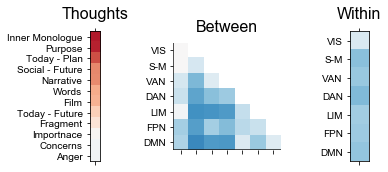

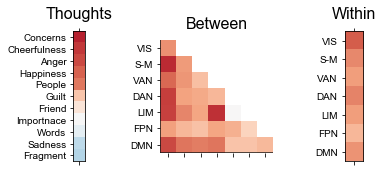

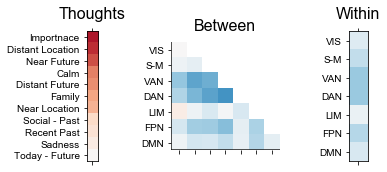

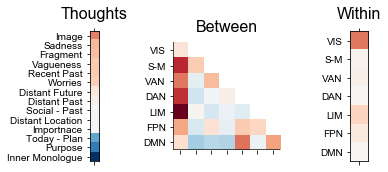

In [59]:
set_text_size(10)
for i in range(n):
    # thought probe
    vi, cur_v_labels = sparse_row(df_v.iloc[:, i])
    
    # between networks
    mat = np.tril(summary_mat[..., i], 0)
    mat[np.triu_indices(mat.shape[0], 1)] = np.nan
    cur_df = pd.DataFrame(mat, columns=yeo7_names, index=yeo7_names)
    
    # within networks
    within_net = np.mean(summary_mat[..., i], axis=0).reshape(7,1)
    
    fig = plt.figure(figsize=(6, 2.5))
    ax = fig.add_subplot(131)
    t = ax.matshow(vi, vmax=v_max, vmin=-v_max, cmap='RdBu_r')
    ax.set_xticks(np.arange(vi.shape[1]))
    ax.set_yticks(np.arange(vi.shape[0]))
    ax.set_xticklabels([' '])
    ax.set_yticklabels(cur_v_labels)
    ax.set_title('Thoughts', fontsize=16)
#     divider = make_axes_locatable(ax)
#     cax2 = divider.append_axes("right", size="50%", pad="30%")
#     cb = fig.colorbar(t, cax=cax2)
#     cb.ax.tick_params(labelsize=10)
    
    ax = fig.add_subplot(132)
    m1 = ax.matshow(cur_df.values, vmax=u_max, vmin=-u_max, cmap='RdBu_r')
    ax.set_xticks(np.arange(cur_df.shape[1]))
    ax.set_yticks(np.arange(cur_df.shape[0]))
    ax.set_xticklabels([' '])
    ax.set_yticklabels(yeo7_names)
    ax.set_title('Between', fontsize=16)
    ax.set_frame_on(False)
    ax.plot([-0.5, -0.5], [-0.5, 6.5], ls='-', c='.1')
    ax.plot([-0.5, 6.5], [6.5, 6.5], ls='-', c='.1')
    ax.xaxis.set_ticks_position('bottom')
    
    ax = fig.add_subplot(133)
    m2 = ax.matshow(within_net, vmax=u_max, vmin=-u_max, cmap='RdBu_r')
    ax.set_xticks(np.arange(within_net.shape[1]))
    ax.set_yticks(np.arange(within_net.shape[0]))
    ax.set_xticklabels(' ')
    ax.set_yticklabels(yeo7_names)
    ax.set_title('Within', fontsize=16)
    
#     divider = make_axes_locatable(ax)
#     cax2 = divider.append_axes("right", size="30%", pad="20%")
#     cb = fig.colorbar(m2, cax=cax2)
#     cb.ax.tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig('./reports/plots/yeo7nodes_bwsummary_{}.png'.format(i + 1), dpi=300)
    plt.show()

In [21]:
master = []
vmax = np.abs(v).max()
vmin = -vmax
for i in range(4):
    rescale = (v[:,i] - vmin) / (vmax - vmin)
    colors_hex = []
    for c in cm.RdBu_r(rescale):
        colors_hex.append(matplotlib.colors.to_hex(c))
    master.append(colors_hex)
colors_hex = np.array(master).T
df_v_color = pd.DataFrame(colors_hex, index=dataset['MRIQ_labels'])
df_v_color.to_csv('./reports/plots/wordcloud_colors.csv')
df_v.to_csv('./reports/plots/v.csv')

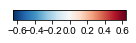

In [49]:
# word cloud colorbar 
set_text_size(10)

fig = plt.figure(figsize=(2, 0.7))
ax = fig.add_subplot(111)
cmap = cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm, orientation='horizontal')
plt.tight_layout()
plt.savefig('./reports/plots/wordcloud_cb.png', transparent=True, dpi=300)
plt.show()

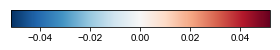

In [44]:
# word cloud colorbar 
set_text_size(10)

fig = plt.figure(figsize=(4, 0.8))
ax = fig.add_subplot(111)
cmap = cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-u_max, vmax=u_max)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm, orientation='horizontal')
plt.tight_layout()
plt.savefig('./reports/plots/fc_cb.png', transparent=True, dpi=300)
plt.show()

# within network connectivity

In [ ]:
for k in range(n):
    df = pd.DataFrame(u_mat[k], columns=df_label.iloc[:, -2].values, index=df_label.iloc[:, -2].values)
    for net in yeo7_names:
        mat = df.loc[net, net].values
        label_idx = df_label.loc[:, 'Yeo7'] == net
        label_l = df_label.iloc[:, -3][label_idx]
        label_r = df_label.iloc[:, -1][label_idx]
        label = list((label_l + " - " +label_r).values)
        
        set_text_size(8)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        max_val = np.abs(mat).max()
        
        m = ax.matshow(mat, vmax=max_val, vmin=-max_val, cmap='RdBu_r')
        ax.set_xticks(np.arange(mat.shape[1]))
        ax.set_yticks(np.arange(mat.shape[0]))
        ax.set_xticklabels(label, rotation='vertical')
        ax.set_yticklabels(label)
#         ax.set_frame_on(False)
#         ax.plot([-0.5, -0.5], [-0.5, 6.5], ls='-', c='.1')
#         ax.plot([-0.5, 6.5], [6.5, 6.5], ls='-', c='.1')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_title('Component {} - {}'.format(k + 1, net))
        fig.colorbar(m)
        plt.savefig('./reports/plots/withinNetworks/com{}.png'.format(k + 1, net))

In [9]:
for k in range(n):
    df = pd.DataFrame(u_mat[k], columns=df_label.iloc[:, -2].values, index=df_label.iloc[:, -2].values)
    for net in yeo7_names:
        mat = df.loc[net, net].values
        label_idx = df_label.loc[:, 'Yeo7'] == net
        label_l = df_label.iloc[:, -3][label_idx]
        label_r = df_label.iloc[:, -1][label_idx]
        label = list((label_l + " - " +label_r).values)
        
        set_text_size(8)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        max_val = np.abs(mat).max()
        
        m = ax.matshow(mat, vmax=max_val, vmin=-max_val, cmap='RdBu_r')
        ax.set_xticks(np.arange(mat.shape[1]))
        ax.set_yticks(np.arange(mat.shape[0]))
        ax.set_xticklabels(label, rotation='vertical')
        ax.set_yticklabels(label)
#         ax.set_frame_on(False)
#         ax.plot([-0.5, -0.5], [-0.5, 6.5], ls='-', c='.1')
#         ax.plot([-0.5, 6.5], [6.5, 6.5], ls='-', c='.1')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_title('Component {} - {}'.format(k + 1, net))
        fig.colorbar(m)
        plt.savefig('./reports/plots/withinNetworks/com{}_{}.png'.format(k + 1, net))